In [10]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
from astropy.io import ascii
import sys, os, time, argparse, glob
import warnings; warnings.simplefilter('ignore')
sys.path.insert(0, '/global/homes/q/qmxp55/DESI/matches/quality_cuts/')
from extract_bgs import _prepare_optical_wise, _psflike

from astropy.coordinates import SkyCoord
from astropy import units as u

## Loading general catalogue with rmag limit on 21 

This catalogue is the same we've been using for SV tests covering a 1400 deg$^2$ with the only cut in rmag of 21.
    
$$160 < RA < 230$$
$$-2 < DEC < 18$$

In this case, 'bgs_all' is the BGS selection runin up to r-mag = 21 with quality cuts except from the FRACMASKED, FRACIN and FRACFLUX cuts. This because the aim of this notebook is to test these quality cuts.

For 'bgs_aqc', this is the usual BGS after quality cuts but in this case it runs up to r-mag = 21.

In [11]:
cat0 = np.load('/global/homes/q/qmxp55/DESI/matches/BGS_SV/cat0_160_230_-2_18_rmag_21.npy')

In [12]:
bgs_all = get_targtype(cat0, 'all')

rmag = flux_to_mag(cat0['FLUX_R']/cat0['MW_TRANSMISSION_R'])
bgs_fracmask = (cat0['FRACMASKED_G'] < 0.4) & (cat0['FRACMASKED_R'] < 0.4) & (cat0['FRACMASKED_Z'] < 0.4)
bgs_fracflux = (cat0['FRACFLUX_G'] < 5.0) & (cat0['FRACFLUX_R'] < 5.0) & (cat0['FRACFLUX_Z'] < 5.0)
bgs_fracin = (cat0['FRACIN_G'] > 0.3) & (cat0['FRACIN_R'] > 0.3) & (cat0['FRACIN_Z'] > 0.3)

bgs_aqc = (bgs_all) & (bgs_fracmask) & (bgs_fracflux) & (bgs_fracin)
fracs = (bgs_fracmask) & (bgs_fracflux) & (bgs_fracin)

# FIBRE MAGNITUDE CUT

## Eye-inspected sample catalogue

The sample catalogue that was inspected by eye have around $5000$ objects. The selection to generate this sample catalgue is conformed by three different ones:

    1) FM selection: all BGS cuts except for FRACMASKED
    2) FI selection: all BGS cuts except for FRACIN 
    3) FF selection: all BGS cuts except for FRACFLUX
   
Each of this selection was divided into bins of $300$ objects.

As the sample was not uniformly selected we get some weights as follows:

$$w = N_{bin}/300,$$

where $N_{bin}$ is the total number of objects within the bin. Then, higher weights shows a poor reliable data meanwhile lower weights means the data is reliable.

More details at: https://www.icloud.com/keynote/0jAi23IiPVQHB5l-g1Qj0EvoA#utah%5Fmeeting%5Ftalk

In [13]:
fm_samp, fm_good, fm_bad, fm_ns, fm_w, fm_idx = merge_sample(fracPar='fracmasked', 
                                               bininf=['0', '0.2', '0.3', '0.4', '0.5', '0.6', '1'],
                                              fsamp=[1.5e-4, 2.5e-2, 5.4e-2, 1.1e-1, 3.4e-1, 5.2e-1])

0 < fracmasked < 0.2 --> 0.9766 --> 0.01338 --> 0.01003
0.2 < fracmasked < 0.3 --> 0.7826 --> 0.1271 --> 0.0903
0.3 < fracmasked < 0.4 --> 0.5485 --> 0.2207 --> 0.2308
0.4 < fracmasked < 0.5 --> 0.2341 --> 0.6254 --> 0.1405
0.5 < fracmasked < 0.6 --> 0.1538 --> 0.786 --> 0.0602
0.6 < fracmasked < 1 --> 0.1137 --> 0.796 --> 0.0903
1794 nearby objects ~ 0.0169203 %
a) good: 840 --> bad: 768 --> NS: 186
b) good: 840 --> bad: 768 --> NS: 186
fm_size=1794 --> SUM: 1794


In [14]:
fi_samp, fi_good, fi_bad, fi_ns, fi_w, fi_idx = merge_sample(fracPar='fracin', 
                                               bininf=['0', '0.2', '0.3', '0.4', '0.6', '0.8', '1'],
                                              fsamp=[4.5e-2, 3.7e-2, 2.4e-2, 5.7e-3, 1.4e-3, 2.0e-4])

0 < fracin < 0.2 --> 0.1405 --> 0.5117 --> 0.3478
0.2 < fracin < 0.3 --> 0.3612 --> 0.3177 --> 0.3211
0.3 < fracin < 0.4 --> 0.709 --> 0.1338 --> 0.1572
0.4 < fracin < 0.6 --> 0.8395 --> 0.05686 --> 0.1037
0.6 < fracin < 0.8 --> 0.9632 --> 0.02007 --> 0.01672
0.8 < fracin < 1 --> 0.9866 --> 0.003344 --> 0.01003
1794 nearby objects ~ 0.0169203 %
a) good: 1196 --> bad: 312 --> NS: 286
b) good: 1196 --> bad: 312 --> NS: 286
fm_size=1794 --> SUM: 1794


In [15]:
ff_samp, ff_good, ff_bad, ff_ns, ff_w, ff_idx = merge_sample(fracPar='fracflux', 
                                                     bininf=['0', '2', '4', '5', '8', '10'],
                                                    fsamp=[1.9e-4, 3.2e-2, 1.7e-1, 6.8e-2, 3.4e-1])

0 < fracflux < 2 --> 0.9766 --> 0.006689 --> 0.01672
2 < fracflux < 4 --> 0.2308 --> 0.6421 --> 0.1304
4 < fracflux < 5 --> 0.1739 --> 0.7458 --> 0.08027
5 < fracflux < 8 --> 0.214 --> 0.7023 --> 0.08361
8 < fracflux < 10 --> 0.1538 --> 0.7659 --> 0.08027
1495 nearby objects ~ 0.0141003 %
a) good: 523 --> bad: 856 --> NS: 117
b) good: 523 --> bad: 856 --> NS: 117
fm_size=1495 --> SUM: 1496


In [16]:
#merge all weights
cat0_w = np.zeros(len(cat0))
w_list = [fm_w, fi_w, ff_w]
idx_list = [fm_idx, fi_idx, ff_idx]
for i in range(len(w_list)):
    cat0_w[idx_list[i]] = w_list[i][idx_list[i]]
    print(np.sum(cat0_w > 0), np.sum(w_list[i] > 0))
    

1794 1794
3581 1794
5074 1495


In [17]:
cat0_good = (fm_good) | (fi_good) | (ff_good)
cat0_bad = (fm_bad) | (fi_bad) | (ff_bad)

print('Sample good: %i' %(np.sum(cat0_good)))
print('Sample bad: %i' %(np.sum(cat0_bad)))

Sample good: 2557
Sample bad: 1932


COMPLETENESS: 100 %
COMPLETENESS: 100 %


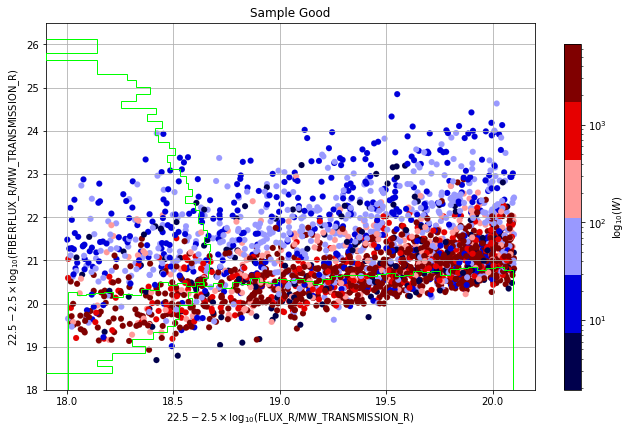

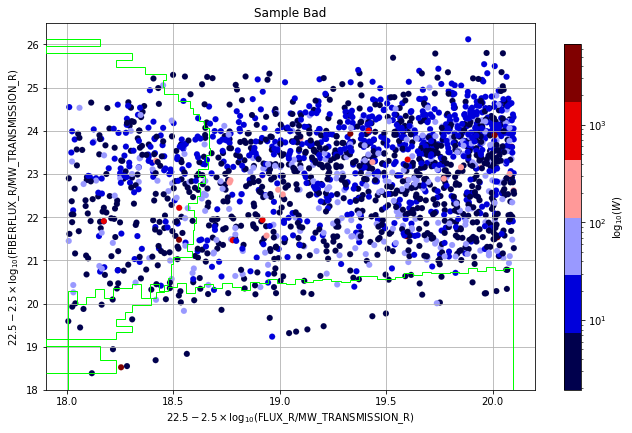

In [18]:
x = flux_to_mag(cat0['FLUX_R']/cat0['MW_TRANSMISSION_R'])
y = flux_to_mag(cat0['FIBERFLUX_R']/cat0['MW_TRANSMISSION_R'])
limit = [17.9, 20.2, 18, 26.5]

frac_density(pars=[x[cat0_good], y[cat0_good], cat0_w[cat0_good]], title='Sample Good', log=True, plot='scatter', limit=limit)
frac_density(pars=[x[cat0_bad], y[cat0_bad], cat0_w[cat0_bad]], title='Sample Bad', log=True, plot='scatter', limit=limit)

#frac_density(pars=[x[cat0_good], y[cat0_good], cat0_w[cat0_good]], title='Sample Good', log=True, plot='hexbin', limit=limit)
#frac_density(pars=[x[cat0_bad], y[cat0_bad], cat0_w[cat0_bad]], title='Sample Bad', log=True, plot='hexbin', limit=limit)

In [19]:
allmask = (cat0['ALLMASK_R'] != 0) | (cat0['ALLMASK_G'] != 0) | (cat0['ALLMASK_Z'] != 0)

Here we have plotted the fraction of `COMPLETENESS` and the fraction of `CONTAMINATION` as a function of `n` of two different functions; one flat or constant and the other lineal:

    1) fibmag < n + rmag (lineal)
    2) fibmag < 20 + n (flat)
    
`COMPLETENESS` and `CONTAMINATION` are defined as:
$$f_{comp} = \frac{N_{good}^{kept}}{N_{good}^{all}}$$

$$f_{cont} = \frac{N_{bad}^{kept}}{N_{bad}^{kept} + N_{good}^{kept}}$$

To find the best `n` where the `CONTAMINATION` is minimum we use:

$$f_{cont}^{2} + (1 - f_{comp}^{2}).$$

Now we repeat this procedure using the `weights`, for this the `COMPLETENESS` and `CONTAMINATION` are calculated as:

$$f_{comp}^{w} = \frac{\sum w_{good}^{kept}}{\sum w_{good}^{all}}$$

$$f_{cont}^{w} = \frac{\sum w_{bad}^{kept}}{\sum w_{bad}^{kept} + \sum w_{good}^{kept}}$$

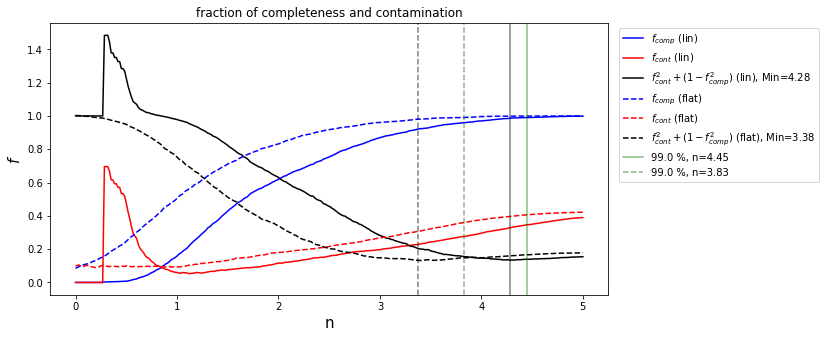

Min (lin) --> n=4.28, f_completeness=0.987, f_contamination=0.328
(lin) --> n=4.45, f_completeness=0.99, f_contamination=0.346
(lin) --> n=4.16, f_completeness=0.98, f_contamination=0.315
Min (cte) --> n=3.38, f_completeness=0.981, f_contamination=0.306
(cte) --> n=3.83, f_completeness=0.99, f_contamination=0.361
(cte) --> n=3.36, f_completeness=0.98, f_contamination=0.305


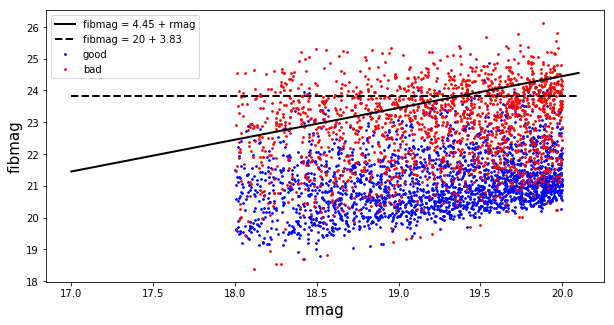

In [49]:
maks20 = rmag < 20
fibmag_mag_scatter(cat0[maks20], cat0_good[maks20], cat0_bad[maks20], w=None, weight=False, 
                   title='fraction of completeness and contamination')

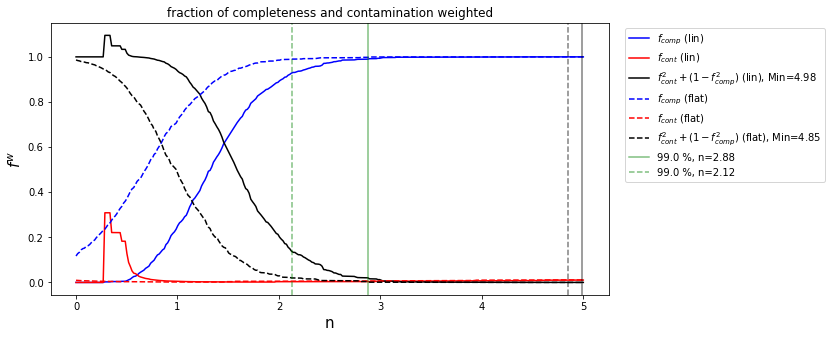

Min (lin) --> n=4.98, f_completeness= 1, f_contamination=0.0106
(lin) --> n=2.88, f_completeness=0.99, f_contamination=0.00387
(lin) --> n=2.58, f_completeness=0.98, f_contamination=0.00344
Min (cte) --> n=4.85, f_completeness= 1, f_contamination=0.0111
(cte) --> n=2.12, f_completeness=0.99, f_contamination=0.00554
(cte) --> n=1.89, f_completeness=0.98, f_contamination=0.00515


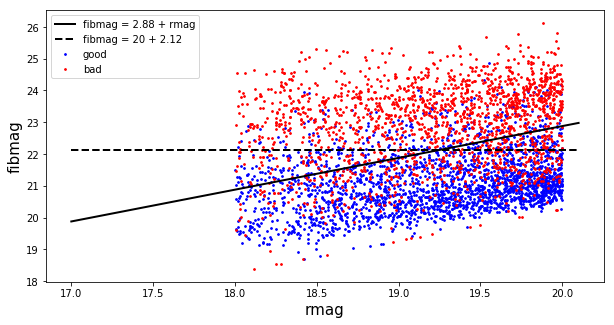

In [47]:
fibmag_mag_scatter(cat0[maks20], cat0_good[maks20], cat0_bad[maks20], w=cat0_w[maks20], weight=True, 
                   title='fraction of completeness and contamination weighted')

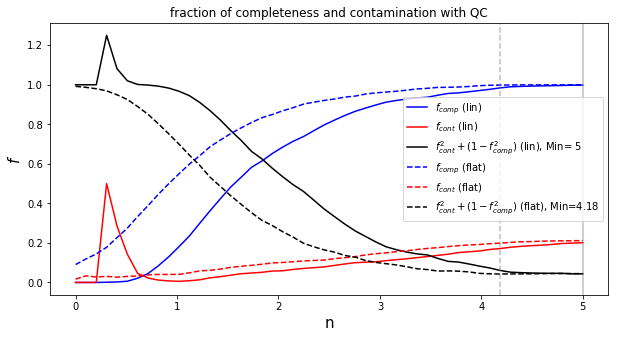

Min (lin) --> n= 5, f_completeness=0.998, f_contamination=0.201
Min (cte) --> n=4.18, f_completeness=0.998, f_contamination=0.199


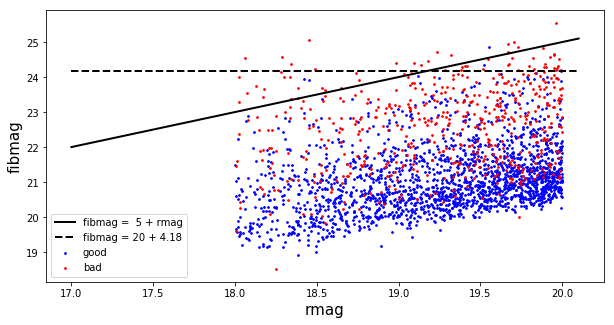

In [22]:
fibmag_mag_scatter(cat0, ((cat0_good) & (fracs) & (maks20)), ((cat0_bad) & (fracs) & (maks20)), 
                  w=cat0_w[maks20], weight=True, 
                   title='fraction of completeness and contamination weighted')

## Postage images

# DEFINITIONS...

In [23]:
def flux_to_mag(flux):
    mag = 22.5 - 2.5*np.log10(flux)
    return mag

In [24]:
def isBGS(gflux=None, rflux=None, zflux=None, w1flux=None, w2flux=None, rfiberflux=None,
          gnobs=None, rnobs=None, znobs=None, gfracmasked=None, rfracmasked=None, zfracmasked=None,
          gfracflux=None, rfracflux=None, zfracflux=None, gfracin=None, rfracin=None, zfracin=None,
          gfluxivar=None, rfluxivar=None, zfluxivar=None, brightstarinblob=None, Grr=None,
          w1snr=None, gaiagmag=None, objtype=None, primary=None, south=True, targtype=None):
    """Definition of BGS target classes. Returns a boolean array.

    Parameters
    ----------
    south : :class:`boolean`, defaults to ``True``
        Use cuts appropriate to the Northern imaging surveys (BASS/MzLS) if ``south=False``,
        otherwise use cuts appropriate to the Southern imaging survey (DECaLS).
    targtype : :class:`str`, optional, defaults to ``faint``
        Pass ``bright`` to use colors appropriate to the ``BGS_BRIGHT`` selection
        or ``faint`` to use colors appropriate to the ``BGS_FAINT`` selection
        or ``faint_ext`` to use colors appropriate to the ``BGS_FAINT_EXTENDED`` selection
	or ``lowq`` to use colors appropriate to the ``BGS_LOW_QUALITY`` selection
	or ``fibmag`` to use colors appropriate to the ``BGS_FIBER_MAGNITUDE`` selection.

    Returns
    -------
    :class:`array_like`
        ``True`` if and only if the object is a BGS target of type ``targtype``.

    Notes
    -----
    - Current version (11/05/18) is version 24 on `the SV wiki`_.
    - See :func:`~desitarget.sv1.sv1_cuts.set_target_bits` for other parameters.
    """
    #_check_BGS_targtype_sv(targtype)

    # ------ Bright Galaxy Survey
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    bgs = primary.copy()

    bgs &= notinBGS_mask(gflux=gflux, rflux=rflux, zflux=zflux, gnobs=gnobs, rnobs=rnobs, znobs=znobs, primary=primary,
                         gfracmasked=gfracmasked, rfracmasked=rfracmasked, zfracmasked=zfracmasked,
                         gfracflux=gfracflux, rfracflux=rfracflux, zfracflux=zfracflux,
                         gfracin=gfracin, rfracin=rfracin, zfracin=zfracin, w1snr=w1snr,
                         gfluxivar=gfluxivar, rfluxivar=rfluxivar, zfluxivar=zfluxivar, Grr=Grr,
                         gaiagmag=gaiagmag, brightstarinblob=brightstarinblob, objtype=objtype, targtype=targtype)
    

    bgs &= isBGS_colors(rflux=rflux, rfiberflux=rfiberflux, south=south, targtype=targtype, primary=primary)
        
    return bgs 


def notinBGS_mask(gflux=None, rflux=None, zflux=None, gnobs=None, rnobs=None, znobs=None, primary=None,
                  gfracmasked=None, rfracmasked=None, zfracmasked=None,
                  gfracflux=None, rfracflux=None, zfracflux=None,
                  gfracin=None, rfracin=None, zfracin=None, w1snr=None,
                  gfluxivar=None, rfluxivar=None, zfluxivar=None, Grr=None,
                  gaiagmag=None, brightstarinblob=None, objtype=None, targtype=None):
    """Standard set of masking cuts used by all BGS target selection classes
    (see, e.g., :func:`~desitarget.cuts.isBGS_faint` for parameters).
    """
    #_check_BGS_targtype_sv(targtype)

    if primary is None:
        primary = np.ones_like(gnobs, dtype='?')
    bgs_qcs = primary.copy()
    bgs = primary.copy()

    # quality cuts definitions
    bgs_qcs &= (gnobs >= 1) & (rnobs >= 1) & (znobs >= 1)
    #bgs_qcs &= (gfracmasked < 0.4) & (rfracmasked < 0.4) & (zfracmasked < 0.4)
    #bgs_qcs &= (gfracflux < 5.0) & (rfracflux < 5.0) & (zfracflux < 5.0)
    #bgs_qcs &= (gfracin > 0.3) & (rfracin > 0.3) & (zfracin > 0.3)
    bgs_qcs &= (gfluxivar > 0) & (rfluxivar > 0) & (zfluxivar > 0)
    bgs_qcs &= ~brightstarinblob
    
    bgs_qcs &= rflux > gflux * 10**(-1.0/2.5)
    bgs_qcs &= rflux < gflux * 10**(4.0/2.5)
    bgs_qcs &= zflux > rflux * 10**(-1.0/2.5)
    bgs_qcs &= zflux < rflux * 10**(4.0/2.5)
    
    if targtype == 'lowq':
        bgs &= Grr > 0.6
        bgs |= gaiagmag == 0
        bgs |= (Grr < 0.6) & (~_psflike(objtype)) & (gaiagmag != 0)
        print('PSF STARS: %i' %(np.sum((Grr < 0.6) & (~_psflike(objtype)) & (gaiagmag != 0))))
        bgs &= ~bgs_qcs
    else:
        bgs &= Grr > 0.6
        bgs |= gaiagmag == 0
        bgs |= (Grr < 0.6) & (~_psflike(objtype)) & (gaiagmag != 0)
        #print('PSF STARS: %i' %(np.sum((Grr < 0.6) & (~_psflike(objtype)) & (gaiagmag != 0))))
        #print('objects that arent galaxies:', np.sum(~bgs))
        bgs &= bgs_qcs

    return bgs


def isBGS_colors(rflux=None, rfiberflux=None, south=True, targtype=None, primary=None):
    """Standard set of masking cuts used by all BGS target selection classes
    (see, e.g., :func:`~desitarget.cuts.isBGS` for parameters).
    """

    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    bgs = primary.copy()

    if targtype == 'lowq':
        bgs &= rflux > 10**((22.5-21.0)/2.5)
    elif targtype == 'bright':
        bgs &= rflux > 10**((22.5-19.5)/2.5)
        #bgs &= bgs_gr_rz
    elif targtype == 'faint':
        bgs &= rflux > 10**((22.5-20.1)/2.5)
        bgs &= rflux <= 10**((22.5-19.5)/2.5)
        #bgs &= bgs_gr_rz
    elif targtype == 'faint_ext':
        bgs &= rflux > 10**((22.5-20.5)/2.5)
        bgs &= rflux <= 10**((22.5-20.1)/2.5)
        #bgs &= bgs_gr_rz
    elif targtype == 'fibmag':
        bgs &= rflux <= 10**((22.5-20.1)/2.5)
        bgs &= rfiberflux > 10**((22.5-21.0511)/2.5)
        #bgs &= bgs_gr_rz
    elif targtype == 'all':
        bgs &= rflux > 10**((22.5-21.0)/2.5)

    return bgs 


In [25]:
def get_targtype(CAT, tarty):
    
    (obs_rflux, gflux, rflux, zflux,
            w1flux, w2flux, rfiberflux, objtype, release, gfluxivar, rfluxivar, zfluxivar,
            gnobs, rnobs, znobs, gfracflux, rfracflux, zfracflux,
            gfracmasked, rfracmasked, zfracmasked,
            gfracin, rfracin, zfracin, gallmask, rallmask, zallmask,
            gsnr, rsnr, zsnr, w1snr, w2snr, dchisq, deltaChi2, brightstarinblob, gaiagmag,
            Grr) = _prepare_optical_wise(CAT)
    
    BGS = isBGS(gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, w2flux=w2flux,
                    rfiberflux=rfiberflux, gnobs=gnobs, rnobs=rnobs, znobs=znobs,
                    gfracmasked=gfracmasked, rfracmasked=rfracmasked, zfracmasked=zfracmasked,
                    gfracflux=gfracflux, rfracflux=rfracflux, zfracflux=zfracflux,
                    gfracin=gfracin, rfracin=rfracin, zfracin=zfracin,
                    gfluxivar=gfluxivar, rfluxivar=rfluxivar, zfluxivar=zfluxivar,
                    brightstarinblob=brightstarinblob, Grr=Grr, w1snr=w1snr, gaiagmag=gaiagmag,
                    objtype=objtype, primary=None, south=True, targtype=tarty)
    
    return BGS

In [26]:
1.5e-4

0.00015

In [27]:
def merge_sample(fracPar='fracmasked', bininf=['0', '0.2', '0.3', '0.4', '0.5', '0.6', '1'],
                fsamp=[1.5e-4, 2.5e-2, 5.4e-2, 1.1e-1, 3.4e-1, 5.2e-1]):
    
    import glob
    for i in range(len(bininf)-1):
        
        fgood = glob.glob("eyeballing/*%s*_%s_rmag*good*" %(fracPar, bininf[i]))
        fbad = glob.glob("eyeballing/*%s*_%s_rmag*bad*" %(fracPar, bininf[i]))
        fns = glob.glob("eyeballing/*%s*_%s_rmag*possible*" %(fracPar, bininf[i]))
        fmp = pd.read_csv(fns[0], sep="\t") 
        fmp.columns = ["ra", "dec", "NS"]
        if len(fgood) > 0:
            fm1 = pd.read_csv(fgood[0], sep="\t")
            fm1.columns = ["ra", "dec", "good"]
            fm1['bad'] = ~((fm1['good']) | (fmp['NS']))
        elif len(fbad) > 0:
            fm1 = pd.read_csv(fbad[0], sep="\t")
            fm1.columns = ["ra", "dec", "bad"]
            fm1['good'] = ~((fm1['bad']) | (fmp['NS']))
        else:
            sys.exit('Error! There is any file staring with %s' %(bininf[i]))

        fm1['NS'] = fmp['NS']
        w = np.ones(len(fm1['NS']))
        fm1['w'] = w*(1./fsamp[i])
        
        if i < 1:
            fm = fm1
        else:
            fm = pd.concat([fm, fm1], ignore_index=False)
        
        print('%s < %s < %s --> %2.4g --> %2.4g --> %2.4g' 
              %(bininf[i], fracPar, bininf[i+1], np.sum(fm1['good'])/len(fm1), 
                np.sum(fm1['bad'])/len(fm1), np.sum(fm1['NS'])/len(fm1) ))
            
    idx2, idx1, d2d, d_ra, d_dec = search_around(fm['ra'], fm['dec'], cat0['RA'], 
                                             cat0['DEC'], search_radius=0.0001)
    
    primary = np.zeros_like(cat0, dtype='?')
    fm_samp = primary.copy()
    fm_good = primary.copy()
    fm_bad = primary.copy()
    fm_ns = primary.copy()
    fm_w = np.zeros(len(cat0))

    fm_samp[idx1] = True
    fm_good[idx1] = fm['good']
    fm_bad[idx1] = fm['bad']
    fm_ns[idx1] = fm['NS']
    fm_w[idx1] = fm['w']
    print('a) good: %i --> bad: %i --> NS: %i' %(np.sum(fm['good']), np.sum(fm['bad']), np.sum(fm['NS'])))
    print('b) good: %i --> bad: %i --> NS: %i' %(np.sum(fm_good), np.sum(fm_bad), np.sum(fm_ns)))
    print('fm_size=%i --> SUM: %i' %(len(fm), np.sum(fm['good'])+np.sum(fm['bad'])+np.sum(fm['NS'])))
    
    return fm_samp, fm_good, fm_bad, fm_ns, fm_w, idx1

In [28]:
def search_around(ra1, dec1, ra2, dec2, search_radius=1., verbose=True):
    '''
    Using the astropy.coordinates.search_around_sky module to find all pairs within
    some search radius.
    Inputs:
    RA and Dec of two catalogs;
    search_radius (arcsec);
    Outputs:
        idx1, idx2: indices of matched objects in the two catalogs;
        d2d: angular distances (arcsec);
        d_ra, d_dec: the differences in RA and Dec (arcsec);
    '''

    # protect the global variables from being changed by np.sort
    ra1, dec1, ra2, dec2 = map(np.copy, [ra1, dec1, ra2, dec2])

    # Matching catalogs
    sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
    sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')
    idx1, idx2, d2d, d3d = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
    if verbose:
        print('%d nearby objects ~ %g %%'%(len(idx1), 100*len(idx1)/len(ra2)))

    # convert distances to numpy array in arcsec
    d2d = np.array(d2d.to(u.arcsec))


    d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
    d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
    ##### Convert d_ra to actual arcsecs #####
    mask = d_ra > 180*3600
    d_ra[mask] = d_ra[mask] - 360.*3600
    mask = d_ra < -180*3600
    d_ra[mask] = d_ra[mask] + 360.*3600
    d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)
    ##########################################

    return idx1, idx2, d2d, d_ra, d_dec

In [48]:
def fibmag_mag_scatter(cat1, mask1, mask2, mask3=None, w=None, weight=False, title=None):
    
    x = flux_to_mag(cat1['FLUX_R']/cat1['MW_TRANSMISSION_R'])
    y = flux_to_mag(cat1['FIBERFLUX_R']/cat1['MW_TRANSMISSION_R'])
    
    plt.figure(figsize=(10,5))
    data = []
    n = np.linspace(0, 5, 300)
    for i in n:
        mask_lin = y < i + 1.0*x
        mask_flat = y < 20 + i
        
        if weight:
            ylabel = r'$f^{w}$'
            Ngk_lin = np.sum(w[(mask1) & (mask_lin)])
            Nbk_lin = np.sum(w[(mask2) & (mask_lin)])
            Nga = np.sum(w[mask1])
        
            Ngk_flat = np.sum(w[(mask1) & (mask_flat)])
            Nbk_flat = np.sum(w[(mask2) & (mask_flat)])
        else:
            ylabel = r'$f$'
            Ngk_lin = np.sum((mask1) & (mask_lin))
            Nbk_lin = np.sum((mask2) & (mask_lin))
            Nga = np.sum(mask1)
        
            Ngk_flat = np.sum((mask1) & (mask_flat))
            Nbk_flat = np.sum((mask2) & (mask_flat))
        
        if Ngk_lin == 0 and Nbk_lin == 0:
            fb = 0 #contamination
        else:
            fb = Nbk_lin/(Nbk_lin + Ngk_lin) #contamination
            
        if Ngk_flat == 0 and Nbk_flat == 0:
            fb2 = 0 #contamination
        else:
            fb2 = Nbk_flat/(Nbk_flat + Ngk_flat) #contamination
            
        fg = Ngk_lin/Nga #completeness
        fg2 = Ngk_flat/Nga #completeness
        
        U_lin = fb**2 + (1 - fg**2)
        U_flat = fb2**2 + (1 - fg2**2)
        
        data.append([i, fg, fb, U_lin, fg2, fb2, U_flat])
    Tab = np.transpose(data)

    compLim = 0.99, 0.98
    
    idx_lin = list(Tab[3]).index(Tab[3].min())
    idx_lin_1 = np.abs(Tab[1] - compLim[0]).argmin()
    idx_lin_2 = np.abs(Tab[1] - compLim[1]).argmin()
    plt.plot(Tab[0], Tab[1], c='blue', label=r'$f_{comp}$ (lin)')
    plt.plot(Tab[0], Tab[2], c='red', label=r'$f_{cont}$ (lin)')
    plt.plot(Tab[0], Tab[3], c='k', label=r'$f_{cont}^{2} + (1 - f_{comp}^{2})$ (lin), Min=%2.3g' %(Tab[0][idx_lin]))
    
    idx_cte = list(Tab[6]).index(Tab[6].min())
    idx_cte_1 = np.abs(Tab[4] - compLim[0]).argmin()
    idx_cte_2 = np.abs(Tab[4] - compLim[1]).argmin()
    plt.plot(Tab[0], Tab[4], c='blue', ls='--', label=r'$f_{comp}$ (flat)')
    plt.plot(Tab[0], Tab[5], c='red', ls='--', label=r'$f_{cont}$ (flat)')
    plt.plot(Tab[0], Tab[6], c='k', ls='--', label=r'$f_{cont}^{2} + (1 - f_{comp}^{2})$ (flat), Min=%2.3g' %(Tab[0][idx_cte]))
    
    plt.axvline(Tab[0][idx_lin], c='k', alpha=0.5)
    plt.axvline(Tab[0][idx_cte], c='k', ls='--', alpha=0.5)
    
    plt.axvline(Tab[0][idx_lin_1], c='green', alpha=0.5, label=r'%s %%, n=%2.3g' %(str(compLim[0]*100), Tab[0][idx_lin_1]))
    plt.axvline(Tab[0][idx_cte_1], c='green', ls='--', alpha=0.5, label=r'%s %%, n=%2.3g' %(str(compLim[0]*100), Tab[0][idx_cte_1]))
    
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.01, 1.0))
    plt.xlabel(r'n', size=15)
    plt.ylabel(ylabel, size=15)
    plt.show()

    print('Min (lin) --> n=%2.3g, f_completeness=%2.3g, f_contamination=%2.3g' %(Tab[0][idx_lin], Tab[1][idx_lin], Tab[2][idx_lin]))
    print('(lin) --> n=%2.3g, f_completeness=%2.3g, f_contamination=%2.3g' %(Tab[0][idx_lin_1], Tab[1][idx_lin_1], Tab[2][idx_lin_1]))
    print('(lin) --> n=%2.3g, f_completeness=%2.3g, f_contamination=%2.3g' %(Tab[0][idx_lin_2], Tab[1][idx_lin_2], Tab[2][idx_lin_2]))
    
    print('Min (cte) --> n=%2.3g, f_completeness=%2.3g, f_contamination=%2.3g' %(Tab[0][idx_cte], Tab[4][idx_cte], Tab[5][idx_cte]))
    print('(cte) --> n=%2.3g, f_completeness=%2.3g, f_contamination=%2.3g' %(Tab[0][idx_cte_1], Tab[4][idx_cte_1], Tab[5][idx_cte_1]))
    print('(cte) --> n=%2.3g, f_completeness=%2.3g, f_contamination=%2.3g' %(Tab[0][idx_cte_2], Tab[4][idx_cte_2], Tab[5][idx_cte_2]))

    plt.figure(figsize=(10,5))
    plt.scatter(x[mask1], y[mask1], s=3, color='blue', label='good')
    plt.scatter(x[mask2], y[mask2], s=3, color='red', label='bad')
    if mask3 is not None:
        plt.scatter(x[mask3], y[mask3], s=3, color='purple', label='extra')

    x1 = np.linspace(17, 20.1, 30)
    y1 = Tab[0][idx_lin_1] + 1.0*x1
    y2 = x1*0 + 20 + Tab[0][idx_cte_1]
    plt.plot(x1, y1, lw=2, c='k', label='fibmag = %2.3g + rmag' %(Tab[0][idx_lin_1]))
    plt.plot(x1, y2, lw=2, c='k', ls='--', label='fibmag = 20 + %2.3g' %(Tab[0][idx_cte_1]))
    plt.legend()
    plt.xlabel('rmag', size=15)
    plt.ylabel('fibmag', size=15)
    #plt.xlim(12, 20)
    #plt.ylim(12.5, 27.5)
    plt.show()

In [30]:
def frac_density(pars, title, log=True, plot='hexbin', limit=None):
    import matplotlib.colors as colors
    
    x = pars[0]
    y = pars[1]
    z = pars[2]
    
    mask = (~np.isnan(y)) & (~np.isinf(y)) & (~np.isnan(x)) & (~np.isinf(x)) & (~np.isnan(z)) & (~np.isinf(z))
    #if limit is not None:
    #    mask &= (coord[0] > limit[0]) & (coord[0] < limit[1]) & (coord[1] > limit[2]) & (coord[1] < limit[3])
    print('COMPLETENESS: %g %%' %(np.sum(mask)*100/len(pars[0])))
    x = x[mask]
    y = y[mask]
    z = z[mask]
    
    fig = plt.figure(figsize=(8, 6))
    
    left, width = 0.1, 0.85
    bottom, height = 0.1, 0.85

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom, width, 0.3]
    rect_histy = [left, bottom, 0.3, height]
    colbar = [1.1, 0.1, 0.1, 0.85]

    axScatter = plt.axes(rect_scatter)
    axScatter.set_title(title)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    if log:
        bins = 'log'
        zlabel = r'$\log_{10}(W)$'
        norm = colors.LogNorm(vmin=z.min(), vmax=z.max())
    else:
        bins = None
        zlabel = r'$W$'
        norm = None
        
    cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8])
    if plot == 'hexbin':
        #pos = axScatter.hexbin(x, y, C=z, gridsize=(80,80), cmap='seismic', bins=None, mincnt=1,label=r'test', vmin=-0.2, vmax=1)
        pos = axScatter.hexbin(x, y, C=z, gridsize=(50,50), cmap='seismic', bins=bins, mincnt=1)
        axScatter.set_facecolor('gray')
        fig.colorbar(pos, cax=cbaxes, label=zlabel)
    if plot == 'scatter':
        pos = axScatter.scatter(x, y, lw=0.1, c=z, cmap=plt.cm.get_cmap('seismic', 6), norm=norm)
        fig.colorbar(pos, cax=cbaxes, label=zlabel)

    axScatter.set_ylabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('FIBERFLUX_R', 'MW_TRANSMISSION_R'))
    axScatter.set_xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('FLUX_R', 'MW_TRANSMISSION_R'))
    #axScatter.set_xlabel(r'$2.5\times \log_{10}$(%s/%s)' %('FLUX_R', xcol))
    axScatter.grid()
    
    binsx = np.linspace(x.min(), x.max(), 50)
    binsy = np.linspace(y.min(), y.max(), 50)
    
    N1 = axHistx.hist(x, bins=binsx, cumulative=False, log=log, histtype='step', align='mid', color='lime', linewidth=1)
    N2 = axHisty.hist(y, bins=binsy, cumulative=False, log=log, histtype='step', align='mid', color='lime', linewidth=1, orientation='horizontal')
    
    if limit:
        axScatter.set_xlim(limit[0], limit[1])
        axScatter.set_ylim(limit[2], limit[3])

    axHistx.axis('off')
    axHisty.axis('off')